Explainable AI for Arctic sea ice forecasting with deep neural networks.

A CNN models was trained to predict the sea ice concentration (SIC, from 0 - 1) in the Barents Sea, with SIC and the change of ocean heat content (OHC) as inputs.

This notebook shows examples using captum to perform XAI analysis on the saved pytorch model.

In [1]:
import numpy as np
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

/home/yangliu/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load and prepare data.

In [2]:
# path
path_data = Path("./data/")
# start and end time of the period of interest
start_year = 2000
end_year = 2017
# number of weeks per year (assuming each month contains 4 weeks)
nweeks = 48
# load preprocessed data - sea ice concentration
sic_xr = xr.load_dataset(path_data / "sic_erai_2000_2017.nc")
sic_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    sic        (year, week, latitude, longitude) float64 0.07345 ... -1.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly Sea Ice Concentration

In [3]:
# load preprocessed data - ocean heat content
ohc_xr = xr.load_dataset(path_data /  "ohc_oras_2000_2017.nc")
ohc_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    ohc        (year, week, latitude, longitude) float64 108.1 108.1 ... 0.0 0.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly ocean heat content (300m) change (Tera Joule) regrid...

In [4]:
# turn dataset into sequences
sic_seq = sic_xr.sic.values.reshape(-1, sic_xr.latitude.size, sic_xr.longitude.size)
ohc_seq = ohc_xr.ohc.values.reshape(-1, ohc_xr.latitude.size, ohc_xr.longitude.size)

# turn masked area from -1 to 0  (remove mask)
sic_seq[sic_seq < 0] = 0

def normalizer(x):
    max_value = np.amax(x)
    min_value = np.amin(x)
    y = (x - min_value)/(max_value - min_value)
    return y

# normalize ohc
ohc_norm_seq = normalizer(ohc_seq)

Build neural network.

In [5]:
class MetNet(nn.Module):
    def __init__(self, input_channels = 2, kernels=[2, 3, 5, 3, 1], dropout = 0.2):
        super().__init__()
        self.kernels = kernels
        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, kernels[0], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(kernels[1], kernels[2], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(kernels[2], kernels[3], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 5
        self.layer5 = nn.Sequential(
            nn.Conv2d(kernels[3], kernels[4], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

Set up the environment and choose parameters for training.

In [6]:
print ("Pytorch version {}".format(torch.__version__))
#use_cuda = torch.cuda.is_available()
#print("Is CUDA available? {}".format(use_cuda))
input_channels = 2
kernels=[2, 3, 5, 3, 1]
dropout = 0.2

Pytorch version 1.10.2


In [7]:
# construct model
model = MetNet(input_channels, kernels, dropout)
# load whole model state
checkpoint = torch.load(Path('./models/metnet_training_checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Model evaluation.

In [8]:
# 12 years data used for training, in total 12 * 48 (weeks) data points (spatial maps)
train_years = 12
# investigate the time of interest in testing set
week_interest = 10
year_interest = 2015
timestep_test = train_years * nweeks + (year_interest - 2012) * nweeks + week_interest
# evalutation mode
model.eval()
X_test = torch.tensor(np.stack((sic_seq[timestep_test,:,:],
                                ohc_norm_seq[timestep_test,:,:]))
                        ).float().view(-1, input_channels, 
                                        sic_xr.latitude.size,
                                        sic_xr.longitude.size)
x_var = torch.autograd.Variable(X_test, requires_grad=False)
pred = model(x_var)

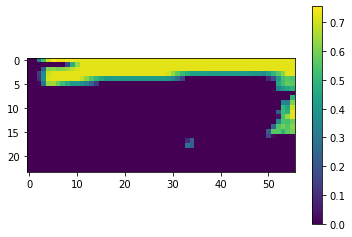

In [9]:
plt.imshow(pred[0,0,:,:].data.numpy())
plt.colorbar()

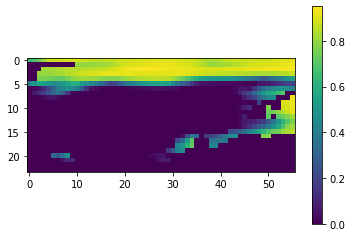

In [10]:
plt.imshow(sic_seq[timestep_test+1,:,:])
plt.colorbar()

Perform XAI.

In [18]:
# xai with captum
from captum.attr import IntegratedGradients, DeepLift, GradientShap

ig = IntegratedGradients(model)

# dl = DeepLift(model)
# gs = GradientShap(model)

# target indicates the cell for explanation
# e.g. target(0, 2, 20) in this case, means we are looking for explanations
# for grid point lat[2] lon[20] in the output
# see the full explanation of target for regressions on captum
# https://captum.ai/docs/faq#how-do-i-set-the-target-parameter-to-an-attribution-method
ig_attr_test = ig.attribute(X_test, n_steps=20, target=(0, 2, 20))

# dl_attr_test = dl.attribute(X_test)
# gs_attr_test = gs.attribute(X_test, X_train)

In [19]:
results = ig_attr_test.detach().numpy()
results.shape

(1, 2, 24, 56)

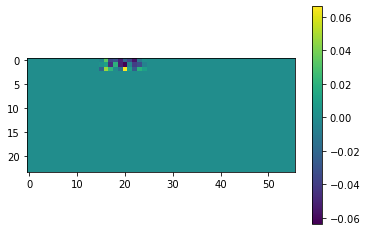

In [20]:
# contribution from SIC field
plt.imshow(results[0,0,:,:])
plt.colorbar()

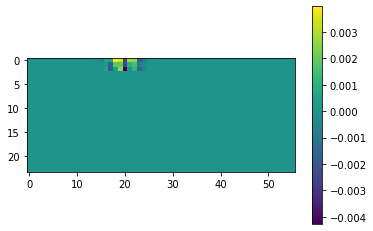

In [21]:
# contribution from OHC field
plt.imshow(results[0,1,:,:])
plt.colorbar()